In [1]:
import os

import comet_ml
import pandas as pd
import math
import random
import pickle
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from utils.model_utils import *
from utils.plot_utils import *

In [2]:
data = pd.read_csv('advanced_models_data.csv', index_col=False)
data.head(10)

,Unnamed: 0,GameID,ShotType,Period,GameTime,XCoord,YCoord,isEmptyNet,isGoal,DistanceToGoal,ShootingAngle,LastEvent,LastEvent_XCoord,LastEvent_YCoord,TimeLastEvent,DistanceLastEvent,Rebound,AngleChange,Speed
0,3,2015020001,Wrist Shot,1,51.0,-55.0,6.0,0,0,35.0,-80.0,HIT,94.0,-34.0,11.0,154.0,False,0.0,14.000000
1,5,2015020001,Snap Shot,1,65.0,-79.0,0.0,0,0,10.0,0.0,GIVEAWAY,-37.0,-28.0,7.0,50.0,False,0.0,7.142857
2,6,2015020001,Snap Shot,1,66.0,-75.0,-1.0,0,0,14.0,86.0,SHOT,-79.0,0.0,1.0,4.0,True,86.0,4.000000
3,9,2015020001,Wrist Shot,1,113.0,-55.0,-36.0,0,0,50.0,43.0,HIT,-91.0,35.0,18.0,80.0,False,0.0,4.444444
4,15,2015020001,Tip-In,1,157.0,-61.0,-1.0,0,0,28.0,88.0,FACEOFF,-69.0,-22.0,5.0,22.0,False,0.0,4.400000
5,19,2015020001,Wrist Shot,1,189.0,63.0,-27.0,0,1,37.0,-44.0,FACEOFF,0.0,0.0,0.0,69.0,False,0.0,0.000000
6,23,2015020001,Wrist Shot,1,234.0,32.0,23.0,0,0,61.0,68.0,GIVEAWAY,33.0,14.0,1.0,9.0,False,0.0,9.000000
7,35,2015020001,Backhand,1,374.0,52.0,-38.0,0,0,53.0,-44.0,FACEOFF,-69.0,-22.0,38.0,122.0,False,0.0,3.210526
8,36,2015020001,Wrist Shot,1,410.0,57.0,-16.0,0,0,36.0,-63.0,SHOT,52.0,-38.0,36.0,23.0,True,19.0,0.638889
9,43,2015020001,Wrist Shot,1,493.0,-68.0,-32.0,0,0,38.0,33.0,FACEOFF,69.0,22.0,6.0,147.0,False,0.0,24.500000


### Two feature selections methods

In [11]:
# selectedfeature_df = data[["DistanceToGoal","LastEvent_XCoord","LastEvent_YCoord","DistanceLastEvent","TimeLastEvent","Speed","isGoal"]]
selectedfeature_df = data[["DistanceToGoal","isEmptyNet","Rebound","AngleChange","DistanceLastEvent","TimeLastEvent","Speed","isGoal"]]
selectedfeature_df['Rebound'] = selectedfeature_df['Rebound'].astype(int)
selectedfeature_df.dropna(inplace=True)
print(selectedfeature_df.isna().sum())

DistanceToGoal       0
isEmptyNet           0
Rebound              0
AngleChange          0
DistanceLastEvent    0
TimeLastEvent        0
Speed                0
isGoal               0
dtype: int64


/tmp/ipykernel_13744/2443329948.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selectedfeature_df['Rebound'] = selectedfeature_df['Rebound'].astype(int)
/tmp/ipykernel_13744/2443329948.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selectedfeature_df.dropna(inplace=True)


In [124]:
from utils.model_utils import *
from utils.plot_utils import *

# feature = ["DistanceToGoal","LastEvent_XCoord","LastEvent_YCoord","DistanceLastEvent","TimeLastEvent","Speed"]
feature = ["DistanceToGoal","isEmptyNet","Rebound","AngleChange","DistanceLastEvent","TimeLastEvent","Speed"]
X_train, y_train, X_val, y_val = get_train_validation(selectedfeature_df, feature, "isGoal", 0.2, balanced=True)
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(47348, 7) (47348,) (64566, 7) (64566, 1)


In [118]:
## Verify if the resampling works and if the data is balanced now
print(verify_label_distribution(y_train))

('The ratio of labels that is non goal', 0.5, 'The ratio of labels that is goal', 0.5)


## Decision Tree Model

In [111]:
from sklearn.metrics import f1_score

def decision_tree_model(data, comet: bool):
    models = {}
    # feature_list = [["DistanceToGoal","LastEvent_XCoord","LastEvent_YCoord","DistanceLastEvent","TimeLastEvent","Speed"]]
    feature_list = [["DistanceToGoal","isEmptyNet","Rebound","AngleChange","DistanceLastEvent","TimeLastEvent","Speed"]]
    experiments = {}
    for feature in feature_list:
        if comet:
            experiment = comet_ml.Experiment(
                # my_key=os.environ.get('COMET_API_KEY')
                # api_key=my_key,???doesn't work with the env file I created
                api_key="uY4cSO6Xov0q2zrVACUZfYdkt",
                project_name="decision_tree",
                workspace="nhl-analytics-milestone-2"
            )
            experiment.set_name("decision_tree")
            experiments["decision_tree"] = experiment
        
        X_train, y_train, X_val, y_val = get_train_validation(data, feature, "isGoal", 0.2, balanced=True)
        lr_model = DecisionTreeClassifier(random_state=42)
        decision_tree_model = DecisionTreeClassifier(random_state=42)
        # train model
        decision_tree_model.fit(X_train, y_train)
        # pickle.dump(decision_tree_model, open("./models/decision_tree2FS" + ".pkl", "wb"))
        # score model (training set)
        score_training = decision_tree_model.score(X_train, y_train)
        # score model (validation set)
        score_validation = decision_tree_model.score(X_val, y_val)
    
        # Class predictions and probabilities 
        val_preds = decision_tree_model.predict(X_val)
        score_prob = decision_tree_model.predict_proba(X_val)[:, 1]
        f1 = f1_score(y_val, val_preds, average="macro")
        models["decision_tree2FS"] = {"model": decision_tree_model, "val_preds": val_preds, "score_prob": score_prob,
                                                       "f1": f1}
        # print(score_training, score_validation, f1)
        if comet:
            experiment.log_model("decision_tree",
                                 "models/decision_tree" + ".pkl")
            experiment.log_metric("train_score", score_training)
            experiment.log_metric("validation_score", score_validation)
            experiment.log_metric("f1_score", f1)
            experiment.log_confusion_matrix(y_val.astype('int32'), val_preds.astype('int32'))
            experiment.end()
        
    return models, experiments

In [112]:
models, experiments = decision_tree_model(selectedfeature_df, comet=False)

In [113]:
models

{'decision_tree2FS': {'model': DecisionTreeClassifier(random_state=42),
  'val_preds': array([1, 0, 0, ..., 0, 0, 0]),
  'score_prob': array([1., 0., 0., ..., 0., 0., 0.]),
  'f1': 0.9248758493921341}}

In [114]:
pred_proba.append(models)
pred_proba

[{'decision_tree1FS': {'model': DecisionTreeClassifier(random_state=42),
   'val_preds': array([1, 0, 0, ..., 0, 0, 0]),
   'score_prob': array([1., 0., 0., ..., 0., 0., 0.]),
   'f1': 0.9410665228468453}},
 {'decision_tree2FS': {'model': DecisionTreeClassifier(random_state=42),
   'val_preds': array([1, 0, 0, ..., 0, 0, 0]),
   'score_prob': array([1., 0., 0., ..., 0., 0., 0.]),
   'f1': 0.9248758493921341}}]

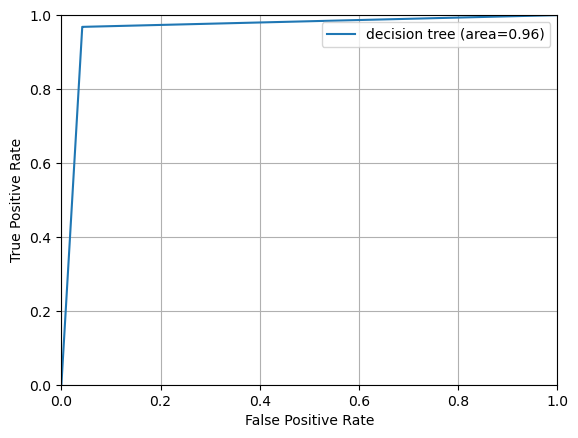

In [12]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

models, experiments = decision_tree_model(selectedfeature_df, comet=False)

feature_list = [["DistanceToGoal","ShootingAngle","DistanceLastEvent","TimeLastEvent"]]


X_train, y_train, X_val, y_val = get_train_validation(selectedfeature_df, ["DistanceToGoal","ShootingAngle","DistanceLastEvent","TimeLastEvent"], "isGoal", 0.2, balanced=True)
labels = ['decision tree']
linestyles = ['-']
pred_proba = []
pred_proba.append(models['decision_tree']['score_prob'])

np.random.seed(42)
pred_random_model = np.random.uniform(size=len(y_val))
pred_proba.append(pred_random_model)

y_val_p = [y_val for i in range(1)]
plot_roc_curve(pred_proba, y_val_p, linestyles, labels)
# print(pred_proba)
# plot_goal_rate(pred_proba, y_val, labels)

In [1]:
# percentile, percentile_pred, y_valid_df = shot_prob_model_percentile(pred_proba[0], y_val[0])
# print(y_valid_df.head(20))

# plot_goal_rate(pred_proba, y_val, labels)

In [17]:
# plot_cumulative_sum(pred_proba, y_val, labels)|

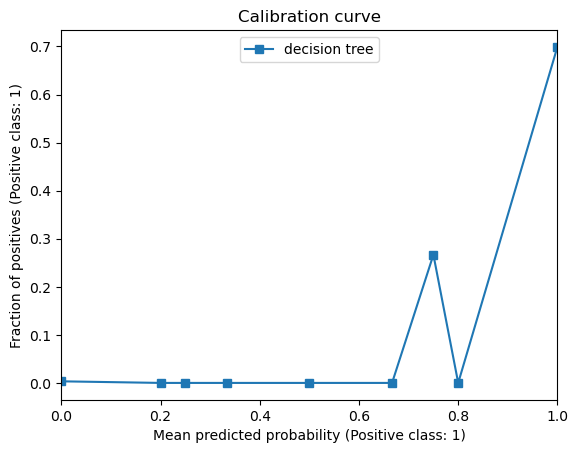

In [21]:
plot_calibration(pred_proba, y_val_p, labels)

/tmp/ipykernel_4645/1952040639.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile_bin = y1_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))


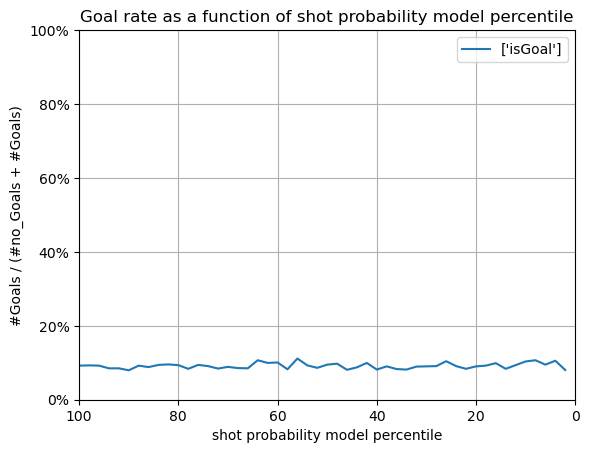

In [13]:
import seaborn as sns
import matplotlib.ticker as mtick

label = ["isGoal"]
percentile = np.arange(0, 102, 2)
pred_percentile = np.percentile(pred_proba[1], percentile)
pred_percentile = np.concatenate([[0], pred_percentile])
pred_percentile = np.unique(pred_percentile)
y1_val_df = pd.DataFrame(y_val)
y1_val_df.rename(columns={ y1_val_df.columns[0]: "isGoal" }, inplace = True)
y1_val_df['percentile_bin'] = pd.cut(pred_proba[1], pred_percentile, include_lowest=True)
bins = np.linspace(0, 100, len(y1_val_df['percentile_bin'].unique()))[1:]
goal_rate_by_percentile_bin = y1_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
g = sns.lineplot(x=bins, y=goal_rate_by_percentile_bin[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('shot probability model percentile')
plt.ylabel('#Goals / (#no_Goals + #Goals)')
plt.title('Goal rate as a function of shot probability model percentile')
plt.grid(True)
plt.show()

/tmp/ipykernel_4645/3668657854.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_goals_by_percentile = y1_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)


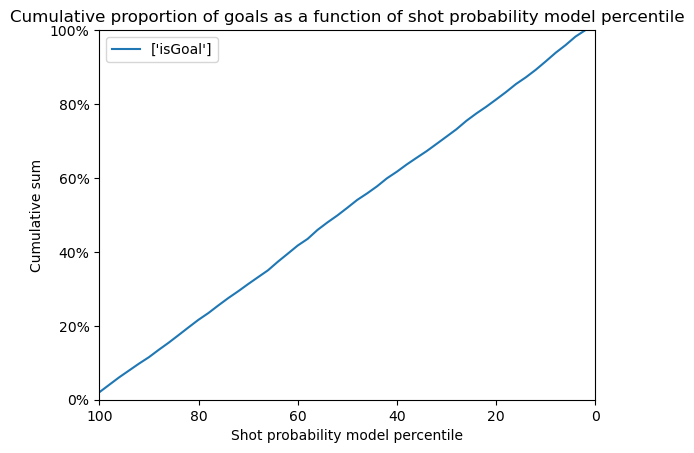

In [15]:
number_goal_sum = (y_val==1).sum()
sum_goals_by_percentile = y1_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
cumu_sum_goals = sum_goals_by_percentile[::-1].cumsum(axis=0)[::-1]
bins = np.linspace(0, 100, len(y1_val_df['percentile_bin'].unique()))[1:]

g = sns.lineplot(x=bins, y=cumu_sum_goals[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
        
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('Shot probability model percentile')
plt.ylabel('Cumulative sum')
plt.title('Cumulative proportion of goals as a function of shot probability model percentile')
plt.show()

## Random Forest Model

In [125]:
from sklearn.metrics import f1_score

def random_forest_model(data, comet: bool):
    models = {}
    # feature_list = [["DistanceToGoal","LastEvent_XCoord","LastEvent_YCoord","DistanceLastEvent","TimeLastEvent","Speed"]]
    feature_list = [["DistanceToGoal","isEmptyNet","Rebound","AngleChange","DistanceLastEvent","TimeLastEvent","Speed"]]
    experiments = {}
    for feature in feature_list:
        if comet:
            experiment = comet_ml.Experiment(
                # my_key=os.environ.get('COMET_API_KEY')
                # api_key=my_key,???doesn't work with the env file I created
                api_key="uY4cSO6Xov0q2zrVACUZfYdkt",
                project_name="random_forest",
                workspace="nhl-analytics-milestone-2"
            )
            experiment.set_name("random_forest")
            experiments["random_forest"] = experiment
        
        X_train, y_train, X_val, y_val = get_train_validation(data, feature, "isGoal", 0.2, balanced=True)
        lr_model = RandomForestClassifier(random_state=42)
        random_forest_model = RandomForestClassifier(random_state=42)
        # train model
        random_forest_model.fit(X_train, y_train)
        pickle.dump(random_forest_model, open("./models/random_forest2FS" + ".pkl", "wb"))
        # score model (training set)
        score_training = random_forest_model.score(X_train, y_train)
        # score model (validation set)
        score_validation = random_forest_model.score(X_val, y_val)
    
        # Class predictions and probabilities 
        val_preds = random_forest_model.predict(X_val)
        score_prob = random_forest_model.predict_proba(X_val)[:, 1]
        f1 = f1_score(y_val, val_preds, average="macro")
        models["random_forest2FS"] = {"model": random_forest_model, "val_preds": val_preds, "score_prob": score_prob,
                                                       "f1": f1}
        # print(score_training, score_validation, f1)
        if comet:
            experiment.log_model("random_forest",
                                 "models/random_forest" + ".pkl")
            experiment.log_metric("train_score", score_training)
            experiment.log_metric("validation_score", score_validation)
            experiment.log_metric("f1_score", f1)
            experiment.log_confusion_matrix(y_val.astype('int32'), val_preds.astype('int32'))
            experiment.end()
        
    return models, experiments

In [126]:
models, experiments = random_forest_model(selectedfeature_df, comet=False)
models

{'random_forest2FS': {'model': RandomForestClassifier(random_state=42),
  'val_preds': array([1, 0, 0, ..., 0, 0, 0]),
  'score_prob': array([1., 0., 0., ..., 0., 0., 0.]),
  'f1': 0.933623305763802}}

In [127]:
pred_proba.append(models)
pred_proba

[{'decision_tree1FS': {'model': DecisionTreeClassifier(random_state=42),
   'val_preds': array([1, 0, 0, ..., 0, 0, 0]),
   'score_prob': array([1., 0., 0., ..., 0., 0., 0.]),
   'f1': 0.9410665228468453}},
 {'decision_tree2FS': {'model': DecisionTreeClassifier(random_state=42),
   'val_preds': array([1, 0, 0, ..., 0, 0, 0]),
   'score_prob': array([1., 0., 0., ..., 0., 0., 0.]),
   'f1': 0.9248758493921341}},
 {'random_forest1FS': {'model': RandomForestClassifier(random_state=42),
   'val_preds': array([1, 0, 0, ..., 0, 0, 0]),
   'score_prob': array([1., 0., 0., ..., 0., 0., 0.]),
   'f1': 0.9644422843185536}},
 {'random_forest2FS': {'model': RandomForestClassifier(random_state=42),
   'val_preds': array([1, 0, 0, ..., 0, 0, 0]),
   'score_prob': array([1., 0., 0., ..., 0., 0., 0.]),
   'f1': 0.933623305763802}}]

### Compare decision tree and random forest models with 2 different feature selection methods together

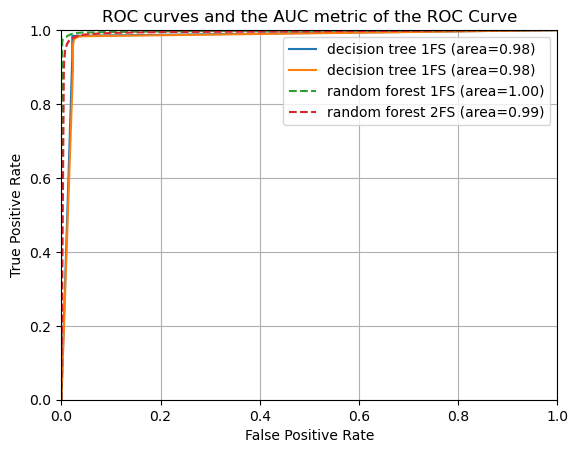

In [13]:
X_train, y_train, X_val, y_val = get_train_validation(selectedfeature_df, ["DistanceToGoal","isEmptyNet","Rebound","AngleChange","DistanceLastEvent","TimeLastEvent","Speed"], "isGoal", 0.2, balanced=True)
y_val = [y_val for i in range(4)]

labels = ['decision tree 1FS', 'decision tree 1FS', 'random forest 1FS', 'random forest 2FS']
linestyles = ['-', '-', '--', '--']
plot_roc_curve(pred_probability, y_val, linestyles, labels, "roc_dt")

In [144]:
pred_probability, y_val

([array([1., 0., 0., ..., 0., 0., 0.]),
  array([1., 0., 0., ..., 0., 0., 0.]),
  array([1., 0., 0., ..., 0., 0., 0.]),
  array([1., 0., 0., ..., 0., 0., 0.])],
 [array([[1],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]),
  array([[1],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]),
  array([[1],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]),
  array([[1],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]])])

In [146]:
labels

['decision tree 1FS',
 'decision tree 1FS',
 'random forest 1FS',
 'random forest 2FS']

/home/cheng-ubuntu/Documents/ift6758/project/utils/plot_utils.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile_bin = y_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
/home/cheng-ubuntu/Documents/ift6758/project/utils/plot_utils.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile_bin = y_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
/home/cheng-ubuntu/Documents/ift6758/project/utils/plot_utils.py:84: FutureWarning: The default of observed=False is deprecated and will be changed to True in a f

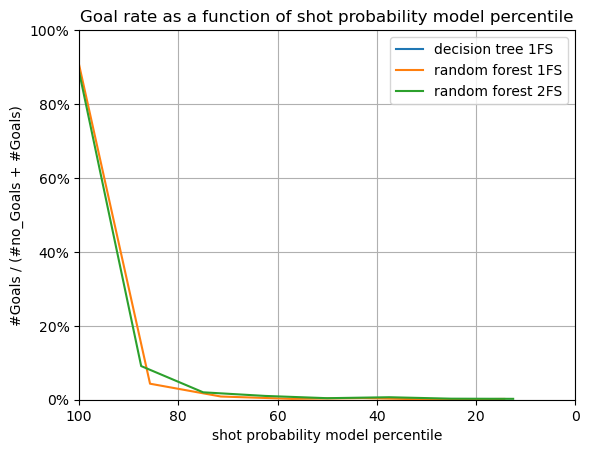

In [14]:
X_train, y_train, X_val, y_val = get_train_validation(selectedfeature_df, ["DistanceToGoal","isEmptyNet","Rebound","AngleChange","DistanceLastEvent","TimeLastEvent","Speed"], "isGoal", 0.2, balanced=True)
y_val = [y_val for i in range(4)]

labels = ['decision tree 1FS', 'decision tree 1FS', 'random forest 1FS', 'random forest 2FS']
linestyles = ['-', '-', '--', '--']

percentile, percentile_pred, y_valid_df = shot_prob_model_percentile(pred_probability[1], y_val[1])
# print(y_valid_df.head(20))

plot_goal_rate(pred_probability, y_val, labels, "dt_goal_rate")

/home/cheng-ubuntu/Documents/ift6758/project/utils/plot_utils.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_goals_by_percentile = y_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
/home/cheng-ubuntu/Documents/ift6758/project/utils/plot_utils.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_goals_by_percentile = y_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
/home/cheng-ubuntu/Documents/ift6758/project/utils/plot_utils.py:115: FutureWarning: The default of observed=False is deprecated and will be changed to Tr

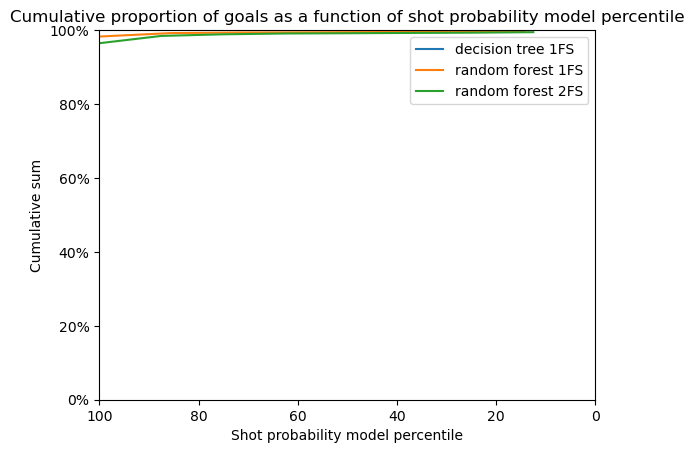

In [15]:
X_train, y_train, X_val, y_val = get_train_validation(selectedfeature_df, ["DistanceToGoal","isEmptyNet","Rebound","AngleChange","DistanceLastEvent","TimeLastEvent","Speed"], "isGoal", 0.2, balanced=True)
y_val = [y_val for i in range(4)]

labels = ['decision tree 1FS', 'decision tree 1FS', 'random forest 1FS', 'random forest 2FS']
linestyles = ['-', '-', '--', '--']
plot_cumulative_sum(pred_probability, y_val, labels, "dt_cumulative")

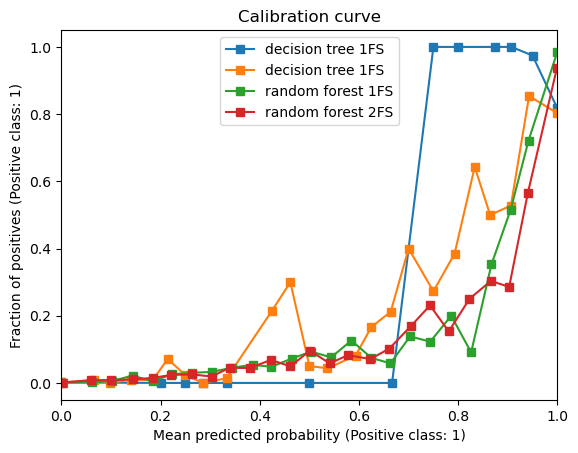

In [16]:
X_train, y_train, X_val, y_val = get_train_validation(selectedfeature_df, ["DistanceToGoal","isEmptyNet","Rebound","AngleChange","DistanceLastEvent","TimeLastEvent","Speed"], "isGoal", 0.2, balanced=True)
y_val = [y_val for i in range(4)]

plot_calibration(pred_probability, y_val, labels, "dt_calibration")
# y_val

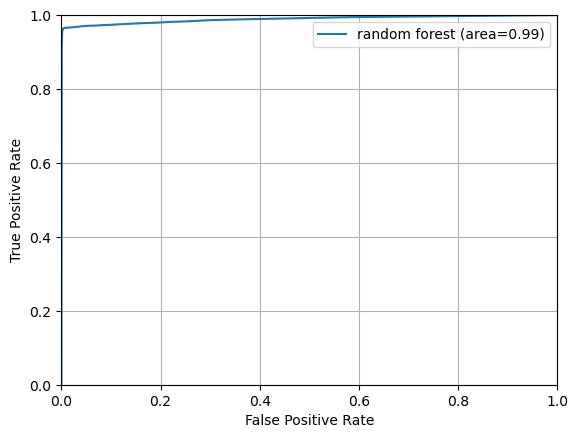

In [26]:
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc

models, experiments = random_forest_model(selectedfeature_df, comet=False)

feature_list = [["DistanceToGoal","ShootingAngle","DistanceLastEvent","TimeLastEvent"]]


X_train, y_train, X_val, y_val = get_train_validation(selectedfeature_df, ["DistanceToGoal","ShootingAngle","DistanceLastEvent","TimeLastEvent"], "isGoal", 0.2, balanced=True)
labels = ['random forest']
linestyles = ['-']
pred_proba = []
pred_proba.append(models['random_forest']['score_prob'])

np.random.seed(42)
pred_random_model = np.random.uniform(size=len(y_val))
pred_proba.append(pred_random_model)

y_val_p = [y_val for i in range(1)]
plot_roc_curve(pred_proba, y_val_p, linestyles, labels)
# print(pred_proba)
# plot_goal_rate(pred_proba, y_val, labels)

/tmp/ipykernel_4645/1952040639.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  goal_rate_by_percentile_bin = y1_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))


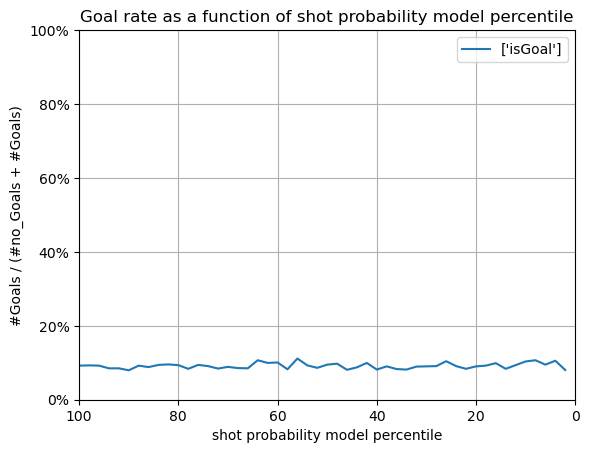

In [27]:
import seaborn as sns
import matplotlib.ticker as mtick

label = ["isGoal"]
percentile = np.arange(0, 102, 2)
pred_percentile = np.percentile(pred_proba[1], percentile)
pred_percentile = np.concatenate([[0], pred_percentile])
pred_percentile = np.unique(pred_percentile)
y1_val_df = pd.DataFrame(y_val)
y1_val_df.rename(columns={ y1_val_df.columns[0]: "isGoal" }, inplace = True)
y1_val_df['percentile_bin'] = pd.cut(pred_proba[1], pred_percentile, include_lowest=True)
bins = np.linspace(0, 100, len(y1_val_df['percentile_bin'].unique()))[1:]
goal_rate_by_percentile_bin = y1_val_df.groupby(by=['percentile_bin']).apply(lambda f: f['isGoal'].sum()/len(f))
g = sns.lineplot(x=bins, y=goal_rate_by_percentile_bin[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('shot probability model percentile')
plt.ylabel('#Goals / (#no_Goals + #Goals)')
plt.title('Goal rate as a function of shot probability model percentile')
plt.grid(True)
plt.show()

/tmp/ipykernel_4645/3668657854.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sum_goals_by_percentile = y1_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)


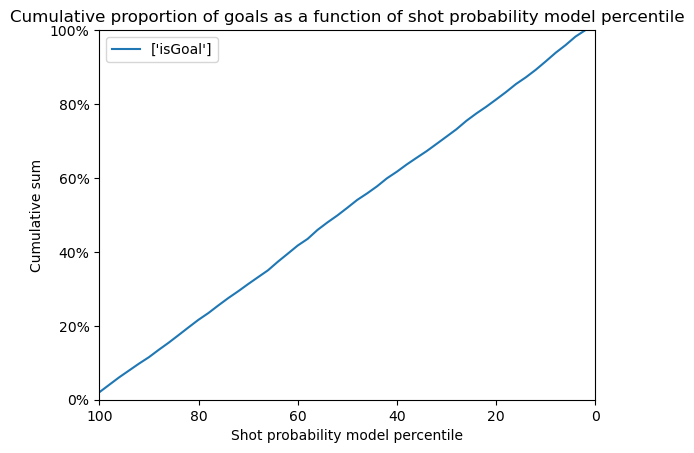

In [28]:
number_goal_sum = (y_val==1).sum()
sum_goals_by_percentile = y1_val_df.groupby(by='percentile_bin').apply(lambda f: f['isGoal'].sum()/number_goal_sum)
cumu_sum_goals = sum_goals_by_percentile[::-1].cumsum(axis=0)[::-1]
bins = np.linspace(0, 100, len(y1_val_df['percentile_bin'].unique()))[1:]

g = sns.lineplot(x=bins, y=cumu_sum_goals[1:]*100, label=label)
ax = g.axes
ax.yaxis.set_major_formatter(mtick.PercentFormatter(100))
        
plt.xlim(100, 0)
plt.ylim(0, 100)
plt.xlabel('Shot probability model percentile')
plt.ylabel('Cumulative sum')
plt.title('Cumulative proportion of goals as a function of shot probability model percentile')
plt.show()

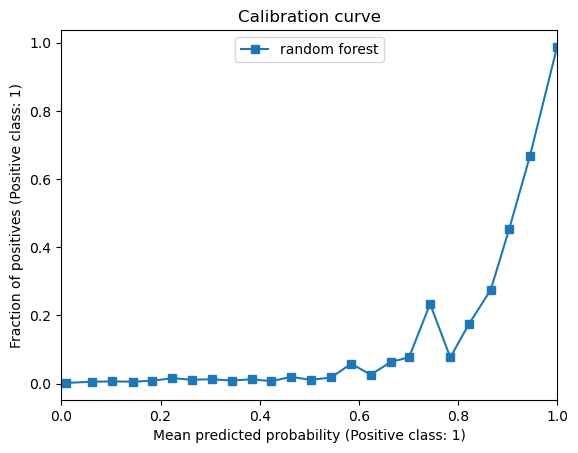

In [29]:
plot_calibration(pred_proba, y_val_p, labels)